<a href="https://colab.research.google.com/github/dnguyend/ManNullRange/blob/master/colab/WeightedPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone  https://github.com/pymanopt/pymanopt.git
import sys
sys.path.append("/content/pymanopt")





Cloning into 'pymanopt'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4127 (delta 0), reused 0 (delta 0), pack-reused 4124
Receiving objects: 100% (4127/4127), 899.14 KiB | 13.83 MiB/s, done.
Resolving deltas: 100% (2876/2876), done.


In [2]:
from pymanopt import Problem
from pymanopt.solvers import TrustRegions
from pymanopt.function import Callable

In [3]:
!git clone  https://github.com/dnguyend/ManNullRange.git

Cloning into 'ManNullRange'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (229/229), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 229 (delta 150), reused 100 (delta 58), pack-reused 0
Receiving objects: 100% (229/229), 680.17 KiB | 12.37 MiB/s, done.
Resolving deltas: 100% (150/150), done.


$\newcommand{\sfT}{\mathsf{T}}$
$\newcommand{\Tr}{\mathrm{Tr}}$
## WEIGHTED PCA
Let $A$ be an $n\times n$ matrix. The problem is to minimize $\Tr(A-YPY^{\sfT})W(A-YPY^{\sfT})$
* If $W$ is the identity matrix, this is the PCA problem.
* We treat the case $W$ is a diagonal but not a multiple of the identity matrix
* Optimize with different choices of $\beta$

In [4]:
import numpy as np
from numpy.random import (randint, randn)
from numpy import zeros, trace, allclose
import numpy.linalg as la

from ManNullRange.manifolds.RealPositiveSemidefinite import (
    RealPositiveSemidefinite, psd_ambient, psd_point)
from ManNullRange.manifolds.tools import (sym, extended_lyapunov, asym)
from ManNullRange.tests.test_tools import check_zero, make_sym_pos, random_orthogonal

def solve_weigthed_dist(man, A, Wt, X0, maxiter):
    from pymanopt import Problem
    from pymanopt.solvers import TrustRegions
    from pymanopt.function import Callable
    @Callable
    def cost(S):
        Y, P = S.Y, S.P    
        if not(S.P.dtype == np.float):
            raise(ValueError("Non real"))
        diff = (A - Y @ P @ Y.T)
        val = trace((diff*Wt[None, :]) @ diff.T)
        return val

    @Callable
    def egrad(S):
        Y, P = S.Y, S.P
        """
        Xnew = X0._add_point(dlt*xi)
        diff = A - Y @ P @ Y.T
        diffNew = A - Y @ Xnew.P @ Y.T
        print((np.trace(diffNew.T@(Wt[:, None]*diffNew)) -
               np.trace(diff.T@(Wt[:, None]*diff)))/dlt)

        print(np.trace(xi.tY.T@(-4*sym(A*Wt[None, :])@Y@P +
                                2*(Wt[:, None]*Y)@P@P)))

        print(np.trace(xi.tP.T@(-2*sym((Y.T@(Wt[:, None]*diff)@Y)))))
        """
        return psd_ambient(-4*sym(A*Wt[None, :])@Y@P +
                           2*(Wt[:, None]*Y)@P@P,
                           -2*sym((Y.T*Wt[None, :])@(A@Y - Y @ P)))
    
    @Callable
    def ehess(S, xi):
        Y, P = S.Y, S.P        
        return psd_ambient(
            -4*sym(A*Wt[None, :])@(xi.tY@P + Y@xi.tP) +
            2*(Wt[:, None]*xi.tY)@P@P + 2*(Wt[:, None]*Y)@(xi.tP@P + P@xi.tP),
            -2*sym((xi.tY.T*Wt[None, :])@(A@Y - Y @ P))
            - 2 * sym((Y.T*Wt[None, :])@(A@xi.tY - xi.tY @ P - Y@ xi.tP)))

    if False:
        dlt = 1e-7
        xi = man.randvec(X0)
        Xnew = X0._add_point(dlt*xi)
        print((cost(Xnew) - cost(X0))/dlt)
        print(man.base_inner_ambient(egrad(X0), xi))

        print(check_zero(man._vec((egrad(Xnew) - egrad(X0)).scalar_mul(1/dlt)
                                  - ehess(X0, xi))))

    prob = Problem(
        man, cost, egrad=egrad, ehess=ehess)

    solver = TrustRegions(maxtime=100000, maxiter=maxiter, use_rand=False)
    opt = solver.solve(prob, x=X0, Delta_bar=250)
    return opt


def optim_test_weighted(n, d):
    np.random.seed(0)
    # n, d = (1000, 50)
    # n, d = (50, 10)
    # simple function. Distance to a given matrix
    # || S - A||_F^2
    Y0, _ = np.linalg.qr(randn(n, d))
    P0 = np.diag(randint(1, 1000, d)*.001)
    A0 = sym(Y0 @ P0 @ Y0.T)
    A = sym(randn(n, n))*4e-2 + A0
    Wt = randint(1, 100, n)*.1
    # Wt[:] = 1

    alpha = np.array([1, 1])
    print("alpha %s" % str(alpha))

    beta = alpha[1] * .1
    man = RealPositiveSemidefinite(n, d, alpha=alpha, beta=beta)
    XInit = man.rand()
    opt_pre = solve_weigthed_dist(man, A, Wt, X0=XInit, maxiter=20)

    beta = alpha[1] * 1
    man = RealPositiveSemidefinite(n, d, alpha=alpha, beta=beta)
    opt_mid = solve_weigthed_dist(man, A, Wt, X0=opt_pre, maxiter=20)
    # opt_mid = opt_pre

    beta = alpha[1] * 30
    man = RealPositiveSemidefinite(n, d, alpha=alpha, beta=beta)
    opt = solve_weigthed_dist(man, A, Wt, X0=opt_mid, maxiter=50)

    eig1, _ = la.eigh(opt.P)
    eig2, _ = la.eigh(opt.Y.T@A@opt.Y)
    print(la.norm(eig1 - eig2)/la.norm(eig1))

    opt_mat = opt.Y @ opt.P @ opt.Y.T
    # diff = A0 - opt_mat
    # print(1/n*np.sqrt(np.trace(diff.T@diff)))
    print(1/n*np.sqrt(np.trace(A@A) + np.trace(opt.P@opt.P) -
                      2*np.trace(opt.Y.T@A@opt.Y*opt.P)))
                       

    if False:
        print(A0)
        print(opt_mat)
    print(np.max(np.abs(A0-opt_mat)))

optim_test_weighted(1000, 50)

alpha [1 1]
Optimizing...
                                            f: +1.206349e+06   |grad|: 2.008159e+06
acc       k:     1     num_inner:     3     f: +4.888830e+05   |grad|: 7.832394e+05   reached target residual-kappa (linear)
acc       k:     2     num_inner:     3     f: +1.986492e+05   |grad|: 3.051699e+05   reached target residual-kappa (linear)
acc       k:     3     num_inner:     3     f: +8.147057e+04   |grad|: 1.185767e+05   reached target residual-kappa (linear)
acc       k:     4     num_inner:     3     f: +3.461704e+04   |grad|: 4.595197e+04   reached target residual-kappa (linear)
acc       k:     5     num_inner:     3     f: +1.600353e+04   |grad|: 1.777529e+04   reached target residual-kappa (linear)
acc       k:     6     num_inner:     3     f: +8.628074e+03   |grad|: 6.852137e+03   reached target residual-kappa (linear)
acc       k:     7     num_inner:     3     f: +5.717272e+03   |grad|: 2.621415e+03   reached target residual-kappa (linear)
acc       k:   

# plotting the progress of the optimization
* Copy the output of the run above
* then save the file to your local drive
* then upload as below. Save data to 'opt_data.txt' in your /content folder

In [5]:


from google.colab import files
files.upload()

Saving opt_data.txt to opt_data.txt


{'opt_data.txt': b'import numpy as np\r\nfrom numpy.random import (randint, randn)\r\nfrom numpy import zeros, trace, allclose\r\nimport numpy.linalg as la\r\n\r\nfrom ManNullRange.manifolds.RealPositiveSemidefinite import (\r\n    RealPositiveSemidefinite, psd_ambient, psd_point)\r\nfrom ManNullRange.manifolds.tools import (sym, extended_lyapunov, asym)\r\nfrom ManNullRange.tests.test_tools import check_zero, make_sym_pos, random_orthogonal\r\n\r\ndef solve_weigthed_dist(man, A, Wt, X0, maxiter):\r\n    from pymanopt import Problem\r\n    from pymanopt.solvers import TrustRegions\r\n    from pymanopt.function import Callable\r\n    @Callable\r\n    def cost(S):\r\n        Y, P = S.Y, S.P    \r\n        if not(S.P.dtype == np.float):\r\n            raise(ValueError("Non real"))\r\n        diff = (A - Y @ P @ Y.T)\r\n        val = trace((diff*Wt[None, :]) @ diff.T)\r\n        return val\r\n\r\n    @Callable\r\n    def egrad(S):\r\n        Y, P = S.Y, S.P\r\n        """\r\n        Xnew =

* Run the following code to generate the progress graph

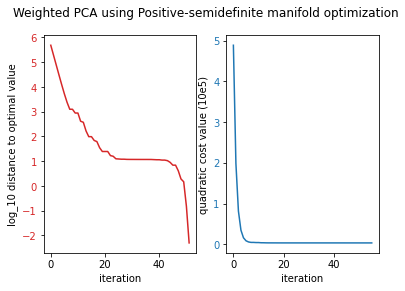

In [17]:

def process_data():
    with open('opt_data.txt') as fi:
        all_lines = fi.readlines()

    def get_next_tk(ll, start):
        return start + ll[start:].index(' ')
        
    def parse_one_line(ll):
        lll = ll.split()
        if 'k:' in lll:
            ktk = lll.index('k:')
            kval = int(lll[ktk+1])
        else:
            kval = None
        
        if 'f:' in lll:
            ftk = lll.index('f:')
            fval = float(lll[ftk+1])
        else:
            fval = None
            
        if '|grad|:' in lll:
            gtk = lll.index('|grad|:')
            gval = float(lll[gtk+1])
        else:
            gval = None
            
        return kval, fval, gval
            
    blk = 0
    lst_k = 1e6
    res = []
    for ll in all_lines:
        k, f, gr = parse_one_line(ll)
        if f is None or k is None:
            continue
        if (k < lst_k):
            blk += 1
        lst_k = k
        res.append((blk, k, f, gr))
            
    res_arr = np.array(res)
    dist_arr = np.log(res_arr[:-1, 2]-res_arr[-1, 2])/np.log(10)

    import matplotlib.pyplot as plt
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Weighted PCA using Positive-semidefinite manifold optimization')
    color = 'tab:red'
    rrg = np.arange(dist_arr.shape[0])    
    ax1.plot(rrg, dist_arr, color=color)
    ax1.set(xlabel='iteration', ylabel='log_10 distance to optimal value')
    
    ax1.tick_params(axis='y', labelcolor=color)

    color = 'tab:blue'        
    rrg = np.arange(res_arr.shape[0])    
    ax2.plot(rrg, res_arr[:, 2]/1e5, color=color)
    ax2.set(xlabel='iteration', ylabel='quadratic cost value (10e5)')
    ax2.tick_params(axis='y', labelcolor=color)
    # fig.tight_layout()

process_data()